# SherLock

## Load Libraries

In [1]:
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sns
import numpy as np
import datetime
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
import pickle

## Load Data

This will cycle through all the data found in the Kaggle subset data, 'archive'.

### Functions Used

In [2]:
# Functions
def editTextFile(f):
    # Read in the file
    with open(f, 'r') as file:
        filedata = file.read()

    # Replace the target string
    filedata = filedata.replace('[msec],size', '[msec];size')

    # Write the file out again
    with open('editTextFile.txt', 'w') as file:
        file.write(filedata)
        
def magVector(df,col1,col2,col3):
    # Calculate magnitude of vector - SQRT(X^2 + Y^2 + Z^2)
    return ((df[col1].pow(2) + df[col2].pow(2) + df[col3].pow(2)).pow(1/2))        

### Loading

In [3]:
# Non-standard columns present, need function to fix
#filename = './archive/AllBroadcasts.csv'
#AllBroadcasts = pd.read_csv(filename)
#AllBroadcasts['UUID'] = AllBroadcasts['UUID'].apply(pd.to_datetime, unit='ms')

# Drop bad rows for now...
#alphabet_string = string.ascii_lowercase
#alphabet_list = list(alphabet_string)

#AllBroadcasts[AllBroadcasts['timestamp'].str().isin(alphabet_list)]

#indexID = AllBroadcasts[(AllBroadcasts['timestamp'] >= 21)].index
#AllBroadcasts.drop(indexID, inplace = True)


#AllBroadcasts.head(3)

In [4]:
filename = './archive/AppPackages.csv'
AppPackages = pd.read_csv(filename)    # Ending columns need to be appended into sherlock_version - make function!

AppPackages[['UUID','InstallTime']] = AppPackages[['UUID', 'InstallTime']].apply(pd.to_datetime, unit='ms')
#AppPackages['sherlock_version'] = AppPackages['sherlock_version'].str.cat(AppPackages['Unnamed: 13'],sep=",")
#AppPackages['sherlock_version'] = AppPackages['sherlock_version'].str.cat(AppPackages['Unnamed: 14'],sep=",")
#AppPackages['sherlock_version'] = AppPackages['sherlock_version'].str.cat(AppPackages['Unnamed: 15'],sep=",")
#AppPackages['sherlock_version'] = AppPackages['sherlock_version'].str.cat(AppPackages['Unnamed: 16'],sep=",")
#AppPackages['sherlock_version'] = AppPackages['sherlock_version'].str.cat(AppPackages['Unnamed: 17'],sep=",")
#AppPackages['sherlock_version'] = AppPackages['sherlock_version'].str.cat(AppPackages['Unnamed: 18'],sep=",")
#AppPackages['sherlock_version'] = AppPackages['sherlock_version'].str.cat(AppPackages['Unnamed: 19'],sep=",")
#AppPackages['sherlock_version'] = AppPackages['sherlock_version'].str.cat(AppPackages['Unnamed: 20'],sep=",")
#AppPackages.drop([])
#AppPackages = AppPackages.set_index('UUID')
print(AppPackages['UserId'].unique())
AppPackages = AppPackages.drop(columns=['UserId'])
print(AppPackages.shape)
#AppPackages.head(3)

['97bb95f55a']
(298, 20)


In [5]:
filename = './archive/Bluetooth.csv'
Bluetooth = pd.read_csv(filename, parse_dates=['Bluetooth_timestamp'])
Bluetooth = Bluetooth.rename(columns={"UserID": "UUID", "UUID": "UserID"})   # Header names swapped apparently
Bluetooth['UUID'] = Bluetooth['UUID'].apply(pd.to_datetime, unit='ms')
#Bluetooth = Bluetooth.set_index('UUID')
print(Bluetooth['UserID'].unique())
Bluetooth = Bluetooth.drop(columns=['UserID'])
print(Bluetooth.shape)
#Bluetooth.head(3)

['97bb95f55a']
(4398, 10)


In [6]:
filename = './archive/Calls.csv'
Calls = pd.read_csv(filename)
Calls[['UUID','Date']] = Calls[['UUID',
                                'Date']].apply(pd.to_datetime, unit='ms')
Calls['FromContacts'] = Calls['FromContacts'].astype(int)                      # Original True/False
#Calls = Calls.set_index('UUID')
print(Calls['UserId'].unique())
Calls = Calls.drop(columns=['UserId'])
print(Calls.shape)
#Calls.head(3)

['97bb95f55a']
(1748, 6)


In [7]:
filename = './archive/Moriarty.csv'
editTextFile(filename)
Moriarty = pd.read_csv('editTextFile.txt')
Moriarty['UUID'] = (pd.to_datetime(Moriarty['UUID'], unit='ms'))
#Moriarty = Moriarty.set_index('UUID')
print(Moriarty['UserId'].unique())
Moriarty = Moriarty.drop(columns=['UserId'])
print(Moriarty.shape)
#Moriarty.head(3)

['97bb95f55a']
(186, 7)


In [8]:
filename = './archive/ScreenOn.csv'
ScreenOn = pd.read_csv(filename, parse_dates=['Timestamp'])
ScreenOn['UUID'] = (pd.to_datetime(ScreenOn['UUID'], unit='ms'))
ScreenOn['ScreenOn'] = ScreenOn['ScreenOn'].astype(int)                    # Original True/False
#ScreenOn = ScreenOn.set_index('UUID')
print(ScreenOn['UserID'].unique())
ScreenOn = ScreenOn.drop(columns=['UserID'])
print(ScreenOn.shape)
#ScreenOn.head(3)

['97bb95f55a']
(1929, 3)


In [9]:
filename = './archive/SMS.csv'
SMS = pd.read_csv(filename)
SMS[['UUID','Date']] = SMS[['UUID','Date']].apply(pd.to_datetime, unit='ms')
SMS[['ContainsURL', 'FromContacts']] = SMS[['ContainsURL', 
                                            'FromContacts']].astype(int)   # Original True/False
#SMS = SMS.set_index('UUID')
print(SMS['UserId'].unique())
SMS = SMS.drop(columns=['UserId'])
print(SMS.shape)
#SMS.head(3)

['97bb95f55a']
(605, 6)


In [10]:
filename = './archive/T0.csv'
T0 = pd.read_csv(filename, parse_dates=['Telephoney_timestemp', 
                                        'SystemInfo_timestemp'])
T0['UUID'] = (pd.to_datetime(T0['UUID'], unit='ms'))
#T0 = T0.set_index('UUID')
print(T0['UserId'].unique())
T0 = T0.drop(columns=['UserId'])
print(T0.shape)
#T0.head(3)

['97bb95f55a']
(42, 28)


In [11]:
filename = './archive/T1.csv'
T1 = pd.read_csv(filename, parse_dates=['GooglePlayLoc_timestamp', 
                                        'CellTower_timestamp', 
                                        'Status_timestamp'])
T1['UUID'] = (pd.to_datetime(T1['UUID'], unit='ms'))
#T1 = T1.set_index('UUID')
print(T1['UserID'].unique())
T1 = T1.drop(columns=['UserID'])
print(T1.shape)
#T1.head(3)

['97bb95f55a']
(24762, 35)


In [12]:
filename = './archive/T2.csv'
T2 = pd.read_csv(filename, parse_dates=['TimeStemp'], low_memory=False)
T2['UUID'] = (pd.to_datetime(T2['UUID'], unit='ms'))
#T2 = T2.set_index('UUID')
print(T2['UserID'].unique())
T2 = T2.drop(columns=['UserID'])
print(T2.shape)
#T2.head(3)

['97bb95f55a']
(78646, 244)


In [13]:
filename = './archive/T3.csv'
T3 = pd.read_csv(filename, parse_dates=['Audio_timestemp', 
                                        'Light_timestamp'], low_memory=False)
T3['UUID'] = (pd.to_datetime(T3['UUID'], unit='ms'))
#T3 = T3.set_index('UUID')
#print(T3['Userid'].unique())
T3 = T3.drop(columns=['Userid'])
print(T3.shape)
#3.head(3)

(144822, 26)


In [14]:
filename = './archive/T4.csv'
T4 = pd.read_csv(filename, parse_dates=['Traffic_timestamp', 
                                        'Battery_timestamp'], low_memory=False)
T4['UUID'] = (pd.to_datetime(T4['UUID'], unit='ms'))
T4['btime'] = (pd.to_datetime(T4['btime'], unit='s'))
#T4 = T4.set_index('UUID')
print(T4['Userid'].unique())
T4 = T4.drop(columns=['Userid'])
print(T4.shape)
#T4.head(3)

['97bb95f55a']
(156017, 115)


In [15]:
filename = './archive/UserPresent.csv'
UserPresent = pd.read_csv(filename, parse_dates=['timestamp'])
UserPresent['UUID'] = (pd.to_datetime(UserPresent['UUID'], unit='ms'))
#UserPresent = UserPresent.set_index('UUID')
print(UserPresent['userID'].unique())
UserPresent = UserPresent.drop(columns=['userID'])
print(UserPresent.shape)
#UserPresent.head(3)

['97bb95f55a']
(467, 2)


In [16]:
filename = './archive/Wifi.csv'
Wifi = pd.read_csv(filename)
Wifi['UUID'] = (pd.to_datetime(Wifi['UUID'], unit='ms'))
#Wifi = Wifi.set_index('UUID')
print(Wifi['UserID'].unique())
Wifi = Wifi.drop(columns=['UserID'])
print(Wifi.shape)
#Wifi.head(3)

['97bb95f55a']
(110477, 5)


## EDA

#### Moriarty exploration

In [17]:
print('Moriarty Sessions: ', Moriarty.SessionType.count())
#Moriarty.groupby('SessionType')['UUID'].nunique()
Moriarty.groupby('ActionType')['UUID'].nunique()

Moriarty Sessions:  186


ActionType
benign        43
malicious    143
Name: UUID, dtype: int64

In [18]:
Moriarty['SessionID'].value_counts()
#Moriarty['SessionID'].unique()
#Moriarty.groupby(['SessionID', 'SessionType']).count()

10    68
12    29
8     26
11    17
9     14
6     12
5     11
3      4
4      4
0      1
Name: SessionID, dtype: int64

In [19]:
pd.set_option('display.max_rows', None)
Moriarty

,UUID,Details,Action,ActionType,SessionType,Version,SessionID
0,2016-04-28 13:56:55.453,Added shortcut to the home screen(app);skype,Add Shortcut,malicious,malicious,5.0,0
1,2016-05-01 05:35:20.285,Login screen launched(login app);Skype,Shortcut Tapped,malicious,malicious,5.0,3
2,2016-05-01 05:35:20.288,App Entered onCreate(),App Mode Change,malicious,malicious,5.0,3
3,2016-05-01 05:35:20.378,App entered onResume(),App Mode Change,malicious,malicious,5.0,3
4,2016-05-01 05:35:39.256,Begin: Sending Password to server,Sending Data,malicious,malicious,5.0,3
5,2016-05-01 10:20:35.506,Login screen launched(login app);Facebook,Shortcut Tapped,malicious,malicious,5.0,4
6,2016-05-01 10:20:35.560,App Entered onCreate(),App Mode Change,malicious,malicious,5.0,4
7,2016-05-01 10:20:35.563,App entered onResume(),App Mode Change,malicious,malicious,5.0,4
8,2016-05-01 10:20:49.661,Begin: Sending Password to server,Sending Data,malicious,malicious,5.0,4
9,2016-05-01 12:25:10.549,App Entered onCreate(),App Mode Change,benign,malicious,5.0,5


In [20]:
pd.set_option('display.max_rows', 15)

Benign actions

In [21]:
Moriarty[Moriarty["ActionType"] == "benign"][["Details", "Action"]]

,Details,Action
9,App Entered onCreate(),App Mode Change
10,App entered onResume(),App Mode Change
20,App Entered onCreate(),App Mode Change
21,App entered onResume(),App Mode Change
22,App entered onPause(),App Mode Change
...,...,...
163,Entered to Game view,View Change
164,Entered to Game view,View Change
165,Entered to Game view,View Change
166,Entered to Game view,View Change


Malicious

In [22]:
Moriarty[Moriarty["ActionType"] == "malicious"][["Details", "Action"]]

,Details,Action
0,Added shortcut to the home screen(app);skype,Add Shortcut
1,Login screen launched(login app);Skype,Shortcut Tapped
2,App Entered onCreate(),App Mode Change
3,App entered onResume(),App Mode Change
4,Begin: Sending Password to server,Sending Data
...,...,...
181,App entered onPause(),App Mode Change
182,Successful send to server(duration [msec];size...,Sending Data
183,Begin: Sending Password to server,Sending Data
184,Successful send to server(duration [msec];size...,Sending Data


In [23]:
mSessList = Moriarty['SessionID'].unique()
minT = []
maxT = []

for i, ses in enumerate(mSessList):
    x = Moriarty[Moriarty['SessionID'] == ses]['UUID'].min()
    y = Moriarty[Moriarty['SessionID'] == ses]['UUID'].max()
    minT.append(x)
    maxT.append(y)

MoriartySessions = pd.concat([pd.Series(mSessList,name='SessionID'),
                              pd.Series(minT,name='minT'),
                              pd.Series(maxT,name='maxT')], axis=1)
MoriartySessions['Duration'] = MoriartySessions['maxT'] - MoriartySessions['minT']
MoriartySessions

,SessionID,minT,maxT,Duration
0,0,2016-04-28 13:56:55.453,2016-04-28 13:56:55.453,0 days 00:00:00
1,3,2016-05-01 05:35:20.285,2016-05-01 05:35:39.256,0 days 00:00:18.971000
2,4,2016-05-01 10:20:35.506,2016-05-01 10:20:49.661,0 days 00:00:14.155000
3,5,2016-05-01 12:25:10.549,2016-05-03 19:20:29.641,2 days 06:55:19.092000
4,6,2016-05-03 19:20:46.068,2016-05-03 19:25:23.237,0 days 00:04:37.169000
5,8,2016-05-08 04:06:47.956,2016-05-08 05:50:28.485,0 days 01:43:40.529000
6,9,2016-05-11 22:33:16.789,2016-05-12 18:44:54.182,0 days 20:11:37.393000
7,10,2016-05-14 19:10:50.904,2016-05-17 10:14:09.707,2 days 15:03:18.803000
8,11,2016-05-17 17:57:43.255,2016-05-18 05:27:00.070,0 days 11:29:16.815000
9,12,2016-05-18 09:53:06.705,2016-05-18 09:59:56.193,0 days 00:06:49.488000


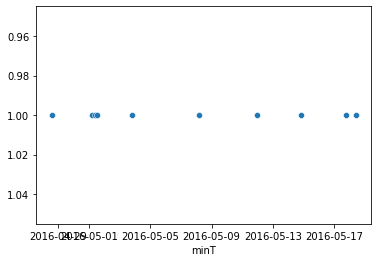

In [24]:
# time series plots of moriarty
sns.scatterplot(data=MoriartySessions, x='minT', y=1)
plt.gca().invert_yaxis()
plt.show()

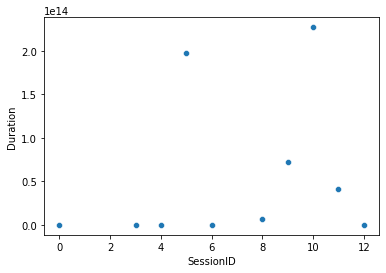

In [25]:
# duration of moriarty
sns.scatterplot(data=MoriartySessions, x='SessionID', y='Duration')
plt.gca().invert_yaxis()
plt.show()

In [26]:
# plot intra-session moriarty behavorior

## Feature engineering of Moriarty

In [27]:
binary = {'benign': 0, 'malicious': 1}
Moriarty = Moriarty.replace({'ActionType':binary})
Moriarty = Moriarty.replace({'SessionType':binary})
Moriarty

,UUID,Details,Action,ActionType,SessionType,Version,SessionID
0,2016-04-28 13:56:55.453,Added shortcut to the home screen(app);skype,Add Shortcut,1,1,5.0,0
1,2016-05-01 05:35:20.285,Login screen launched(login app);Skype,Shortcut Tapped,1,1,5.0,3
2,2016-05-01 05:35:20.288,App Entered onCreate(),App Mode Change,1,1,5.0,3
3,2016-05-01 05:35:20.378,App entered onResume(),App Mode Change,1,1,5.0,3
4,2016-05-01 05:35:39.256,Begin: Sending Password to server,Sending Data,1,1,5.0,3
...,...,...,...,...,...,...,...
181,2016-05-18 09:59:50.825,App entered onPause(),App Mode Change,1,1,5.0,12
182,2016-05-18 09:59:51.466,Successful send to server(duration [msec];size...,Sending Data,1,1,5.0,12
183,2016-05-18 09:59:51.784,Begin: Sending Password to server,Sending Data,1,1,5.0,12
184,2016-05-18 09:59:52.387,Successful send to server(duration [msec];size...,Sending Data,1,1,5.0,12


### Sensors

In [28]:
T2['magAccel'] = magVector(T2,'AccelerometerStat_x_MIDDLE_SAMPLE',
                           'AccelerometerStat_y_MIDDLE_SAMPLE',
                           'AccelerometerStat_z_MIDDLE_SAMPLE')
T2['magMag'] = magVector(T2,'MagneticField_x_MIDDLE_SAMPLE',
                           'MagneticField_y_MIDDLE_SAMPLE',
                           'MagneticField_z_MIDDLE_SAMPLE')
    
T2.head(3)

,UUID,Version,TimeStemp,AccelerometerStat_x_DC_FFT,AccelerometerStat_x_FIRST_IDX_FFT,AccelerometerStat_x_FIRST_VAL_FFT,AccelerometerStat_x_FOURTH_IDX_FFT,AccelerometerStat_x_FOURTH_VAL_FFT,AccelerometerStat_x_MEAN,AccelerometerStat_x_MEAN_FFT,...,AccelerometerStat_z_MIDDLE_SAMPLE,GyroscopeStat_x_MIDDLE_SAMPLE,GyroscopeStat_y_MIDDLE_SAMPLE,GyroscopeStat_z_MIDDLE_SAMPLE,MagneticField_x_MIDDLE_SAMPLE,MagneticField_y_MIDDLE_SAMPLE,MagneticField_z_MIDDLE_SAMPLE,pressure_MIDDLE_SAMPLE,magAccel,magMag
0,2016-04-27 21:32:55.659,2.2,2016-04-28 00:32:55.659,112.709439,256.0,0.070102,254.0,0.079229,-0.557968,1.566997,...,8.746617,-0.010386,-0.007457,-0.007191,-21.90,-9.06,-36.78,991.6177,8.860996,43.754565
1,2016-04-27 21:33:15.462,2.2,2016-04-28 00:33:15.462,14.500483,256.0,0.010774,232.0,0.168699,-0.074745,1.960746,...,8.868722,-0.011185,-0.008522,-0.007723,-22.74,-7.92,-37.86,991.6001,8.886932,44.868849
2,2016-04-27 21:33:35.793,2.2,2016-04-28 00:33:35.793,52.429426,256.0,0.021820,254.0,0.042375,-0.268869,0.786337,...,8.807071,-0.009854,-0.007723,-0.008256,-22.32,-9.54,-36.84,991.6167,8.872734,44.117792


In [29]:
# plots of sensors in time...

## Extract Moriarty across datasets

### Screen On

In [30]:
#Moriarty = Moriarty.set_index('UUID')
#ScreenOn = ScreenOn.set_index('UUID')

Merged = ScreenOn.append(Moriarty, sort=True)
#Merged = Merged.sort_index()
Merged = Merged.sort_values(by='UUID')

Merged['ScreenOn'] = Merged['ScreenOn'].fillna(method="pad")
pd.set_option('display.max_rows', 500)
Merged

,Action,ActionType,Details,ScreenOn,SessionID,SessionType,Timestamp,UUID,Version
0,NaN,NaN,NaN,1.0,NaN,NaN,2016-04-28 02:21:44.991,2016-04-27 23:21:44.991,NaN
1,NaN,NaN,NaN,0.0,NaN,NaN,2016-04-28 02:22:50.982,2016-04-27 23:22:50.983,NaN
2,NaN,NaN,NaN,1.0,NaN,NaN,2016-04-28 02:25:35.929,2016-04-27 23:25:35.929,NaN
3,NaN,NaN,NaN,0.0,NaN,NaN,2016-04-28 02:25:47.083,2016-04-27 23:25:47.083,NaN
4,NaN,NaN,NaN,1.0,NaN,NaN,2016-04-28 02:25:58.975,2016-04-27 23:25:58.976,NaN
...,...,...,...,...,...,...,...,...,...
1924,NaN,NaN,NaN,0.0,NaN,NaN,2016-05-18 23:35:51.390,2016-05-18 20:35:51.391,NaN
1925,NaN,NaN,NaN,1.0,NaN,NaN,2016-05-19 00:35:42.867,2016-05-18 21:35:42.868,NaN
1926,NaN,NaN,NaN,0.0,NaN,NaN,2016-05-19 00:35:52.652,2016-05-18 21:35:52.652,NaN
1927,NaN,NaN,NaN,1.0,NaN,NaN,2016-05-19 00:36:06.226,2016-05-18 21:36:06.226,NaN


In [31]:
filteredMerged = pd.DataFrame()

for index, row in MoriartySessions.iterrows():
    data = Merged[(Merged['UUID'] > row['minT']) & (Merged['UUID'] < row['maxT'])]
    filteredMerged = filteredMerged.append(data, ignore_index=True)
    
filteredMerged[['SessionID', 'SessionType', 'Version']] = filteredMerged[['SessionID', 'SessionType', 'Version']].fillna(method="pad")

In [32]:
# next steps - integer encode unique - aggregate Success...
filteredMerged['Details'].unique()

array(['App Entered onCreate()', 'App entered onResume()', nan,
       'Login screen launched(login app);Facebook',
       'Begin: Sending Password to server', 'App entered onPause()',
       'Successful send to server(duration [msec];size [bytes]);410;30',
       'App entered onStop()', 'Entered to Level view',
       'Entered to Game view',
       'Successful send to server(duration [msec];size [bytes]);271;30',
       'App entered onDestroy()', 'Pop Notification(app);skype',
       'Added shortcut to the home screen(app);skype',
       'Login screen launched(login app);Skype',
       'Successful send to server(duration [msec];size [bytes]);761;27',
       'Successful send to server(duration [msec];size [bytes]);324;30',
       'Successful send to server(duration [msec];size [bytes]);910;30',
       'Successful send to server(duration [msec];size [bytes]);239;30',
       'Successful send to server(duration [msec];size [bytes]);227;27',
       'Successful send to server(duration [msec

In [33]:
#unit type action type
#malicious vs benigin

In [34]:
###### predict is screen on from magnitude

In [35]:
#### predict screen on moriarty...

/Users/kent/opt/anaconda3/envs/sherlock/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


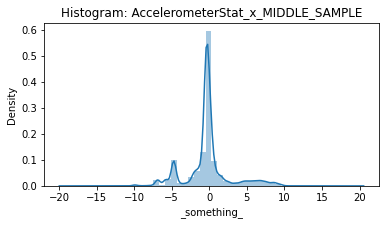

In [36]:
sns.distplot(T2['AccelerometerStat_x_MIDDLE_SAMPLE'])
plt.title('Histogram: AccelerometerStat_x_MIDDLE_SAMPLE')
plt.xlabel('_something_')
f = plt.gcf()
f.set_size_inches(6,3)
plt.show()

### Goofy stuff

In [37]:
t2_accelero = T2[['AccelerometerStat_x_MIDDLE_SAMPLE', 
                  'AccelerometerStat_y_MIDDLE_SAMPLE', 
                  'AccelerometerStat_z_MIDDLE_SAMPLE',
                  'pressure_MIDDLE_SAMPLE']]

t2_accelero.isnull().values.any()
t2_accelero = t2_accelero.dropna()
t2_accelero.isnull().values.any()

t2_accelero_X = t2_accelero[['AccelerometerStat_x_MIDDLE_SAMPLE', 
                  'AccelerometerStat_y_MIDDLE_SAMPLE', 
                  'AccelerometerStat_z_MIDDLE_SAMPLE']]
t2_accelero_y = t2_accelero[['pressure_MIDDLE_SAMPLE']]

X_train, X_test, y_train, y_test = train_test_split(t2_accelero_X, t2_accelero_y, random_state=42)

### Pipeline for pipeline assignment

In [38]:
pipe = Pipeline([('scaler', StandardScaler()), ('lr', LinearRegression())])
pipe.fit(X_train, y_train)
pipe.score(X_test, y_test)

0.050263237819209716

Pretty poor, eh?  Well, what would you expect from a random grab...

### Pickle the model

In [39]:
with open('model.pkl', 'wb') as f:
    # Pickle the 'data' dictionary using the highest protocol available.
    pickle.dump(pipe, f, pickle.HIGHEST_PROTOCOL)

### Create faux-data

In [40]:
print(X_test[0:2].values.tolist())

[[-0.38845924, 0.36272156, 8.802282], [2.2254105, -1.0384849, 8.515577]]


### Tests

In [41]:
from newdata import newdata
newdata

[[-0.38845924, 0.36272156, 8.802282], [2.2254105, -1.0384849, 8.515577]]

In [42]:
with open('model.pkl', 'rb') as f:
    # The protocol version used is detected automatically, so we do not
    # have to specify it.
    pipePKL = pickle.load(f)

In [43]:
predictions = pipePKL.predict(newdata)
print(predictions)

[[970.48399837]
 [968.49615397]]
